In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import argparse
import os
import pickle

import numpy as np
import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi
from tqdm import tqdm

from config import freqs, get_dates, return_delay_split
from GDa.loader import loader
from GDa.session import session_info
from GDa.util import average_stages

#### Functions to load the data

In [3]:
def get_area_mapping(unique_areas):
    """
    Create a mapping from unique region areas to their indices.

    Args:
        unique_areas (ndarray): An array of unique region areas.

    Returns:
        dict: A dictionary mapping region areas to their corresponding indices.

    """
    area2idx = dict(zip(unique_areas, range(len(unique_areas))))
    return area2idx


def get_unique_areas_mapping(session, ttype=1, br=1):
    """
    Get unique region areas and their mapping to indices for a session.

    Args:
        session (str): The session identifier.
        ttype (int, optional): The ttype identifier (default is 1).
        br (int, optional): The br identifier (default is 1).

    Returns:
        tuple: A tuple containing two elements:
            - unique_areas (ndarray): An array of unique region areas.
            - area2idx (dict): A dictionary mapping region areas to their indices.

    """
    unique_areas = []
    for t in range(5):
        for freq in freqs:
            areas, _, _ = load_areas_times(
                session, stage_labels[t], freq, ttype=ttype, br=br
            )
            unique_areas += [np.unique(np.hstack(areas))]
    unique_areas = np.unique(np.concatenate(unique_areas))
    return unique_areas, get_area_mapping(unique_areas)


def load_areas_times(session, epoch, freq, ttype=1, br=1, surr=0, trials=False):
    """
    Load node region and time labels from pickle files.

    Args:
        session (str): The session identifier.
        epoch (int): The epoch identifier.
        freq (str): The frequency identifier.
        ttype (int, optional): The ttype identifier (default is 1).
        br (int, optional): The br identifier (default is 1).
        trials (bool, optional): Whether to load trials data (default is False).

    Returns:
        tuple: A tuple containing two or three elements, depending on the 'trials' parameter.
            - areas (list): List of node region labels.
            - times (list): List of node time labels.
            - trials (list, optional): List of node trial labels (only if trials=True).

    """

    # Load node region label
    fname = os.path.join(
        _path_to_ava,
        f"areas_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_3_surr_{surr}.pkl",
    )
    with open(fname, "rb") as f:
        areas = pickle.load(f)

    # Load node time labelé
    fname = os.path.join(
        _path_to_ava,
        f"times_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_3_surr_{surr}.pkl",
    )
    with open(fname, "rb") as f:
        times = pickle.load(f)

    # Load node time labelé
    fname = os.path.join(
        _path_to_ava,
        f"stim_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_3_surr_{surr}.pkl",
    )
    with open(fname, "rb") as f:
        stims = pickle.load(f)

    if trials:
        # Load node time labelé
        fname = os.path.join(
            _path_to_ava,
            f"trials_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_3_surr_{surr}.pkl",
        )
        with open(fname, "rb") as f:
            trials = pickle.load(f)

        return areas, times, stims, trials

    return areas, times, stims


def get_coavalanche_matrix(areas, times, unique_areas, area2idx):
    """
    Calculate the coavalanche matrix, precedence matrix, and delta values.

    Args:
        areas (list): List of areas.
        times (list): List of times.

    Returns:
        tuple: A tuple containing the coavalanche matrix, precedence matrix, and delta values.

    Raises:
        None
    """

    navalanches = len(areas)

    # unique_areas = np.unique(np.hstack(areas))
    # area2idx = get_area_mapping(unique_areas)
    n_unique_areas = len(unique_areas)

    T = np.zeros((n_unique_areas, n_unique_areas))
    P = np.zeros((n_unique_areas, n_unique_areas))

    delta = np.zeros(navalanches)

    for i in range(navalanches):
        ua = np.unique(areas[i])
        # Index of areas in the avalanche
        idx = [area2idx[area] for area in ua]
        # Time slice of each area
        tava = times[i].astype(int)
        # Avalanche duration
        delta[i] = tava.max() - tava.min()
        # Coactivation
        T[np.ix_(idx, idx)] += 1
        # Precedence
        min_times = []
        for a in ua:
            min_times += [times[i].astype(int)[areas[i] == a].min()]
        min_times = np.array(min_times)
        prec = np.array(min_times)[:, None] < np.array(min_times)
        P[np.ix_(idx, idx)] += prec.astype(int)

    np.fill_diagonal(T, 0)

    T = xr.DataArray(
        T / navalanches,
        dims=("sources", "targets"),
        coords=(unique_areas, unique_areas),
    )
    P = xr.DataArray(
        P / navalanches,
        dims=("sources", "targets"),
        coords=(unique_areas, unique_areas),
    )

    return T, P, delta


def get_st_coavalanche_matrix(areas, times, unique_areas, area2idx, trials):
    """
    Calculate the spatiotemporal co-avalanche matrix for given data.

    Args:
        areas (list): List of node region labels.
        times (list): List of node time labels.
        unique_areas (list): List of unique region labels.
        area2idx (dict): A dictionary mapping region labels to indices.
        trials (list): List of trial labels.

    Returns:
        xr.DataArray: A spatiotemporal co-avalanche matrix as a DataArray,
            with "trials" as the coordinate.

    """

    unique_trials = np.unique(trials)

    T = []

    for trial in unique_trials:

        areas_sel = []
        times_sel = []

        trials_indexes = np.where(trials == trial)[0]
        for i in trials_indexes:
            areas_sel += [areas[i]]
            times_sel += [times[i]]
        out, _, _ = get_coavalanche_matrix(areas_sel, times_sel, unique_areas, area2idx)
        T += [out]
    return xr.concat(T, "trials").assign_coords({"trials": unique_trials})


def get_trials_stim_map(trials, stims):
    unique_trials = np.unique(trials)
    unique_stim = []
    for trial in unique_trials:
        unique_stim += [np.unique(stims[np.where(unique_trials == trial)])]
    unique_stim = np.hstack(unique_stim)

    return dict(zip(unique_trials, unique_stim))

#### Set parameters

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [5]:
tt = 1
br = 1
monkey = "lucy"
freqs = freqs.astype(int)
stage_labels = ["P", "S", "D1", "D2", "Dm"]

sessions = get_dates(monkey)
_path_to_ava = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/avalanches/")

#### Run analysis

In [6]:
def get_CCS(session):
    CCS = []
    TRIALS = []
    STIMS = []
    for freq in freqs:
        T = []
        for epoch in stage_labels:
            areas, times, stims, trials = load_areas_times(
                session, epoch, freq, ttype=tt, br=br, trials=True
            )

            TRIALS += [trials]
            STIMS += [stims]

            unique_areas, area2idx = get_unique_areas_mapping(session)

            T += [
                get_st_coavalanche_matrix(areas, times, unique_areas, area2idx, trials)
            ]
        CCS += [xr.concat(T, "times").sum("sources")]

    trials2stim = get_trials_stim_map(np.hstack(TRIALS), np.hstack(STIMS))

    CCS = (
        xr.concat(CCS, "freqs")
        .assign_coords({"freqs": freqs})
        .rename({"targets": "roi"})
        .transpose("times", "roi", "freqs", "trials")
    )

    stim_vec = [trials2stim[t] for t in CCS.trials.data]

    CCS = CCS.assign_coords({"trials": stim_vec})

    return CCS.transpose("trials", "roi", "freqs", "times")

In [7]:
sxx = []
stim = []
for s_id in tqdm(sessions):

    CCS = get_CCS(s_id).fillna(0)
    sxx += [CCS.isel(roi=[r]) for r in range(len(CCS["roi"]))]
    stim += [CCS.trials.data.astype(int)] * len(CCS["roi"])

100%|█████████████████████████████████████████████████████████| 15/15 [14:37<00:00, 58.50s/it]


### MI workflow

In [9]:
# Convert to DatasetEphy
dt = DatasetEphy(sxx, y=stim, nb_min_suj=2, times="times", roi="roi")

mi_type = "cd"
inference = "rfx"
kernel = None

mcp = "fdr"

mi_type = "cd"

estimator = GCMIEstimator(
    mi_type="cd",
    copnorm=True,
    biascorrect=True,
    demeaned=False,
    tensor=True,
    gpu=False,
    verbose=None,
)
wf = WfMi(mi_type, inference, verbose=True, kernel=kernel, estimator=estimator)

kw = dict(n_jobs=30, n_perm=500)
cluster_th = None

mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)

tvals = wf.tvalues

Definition of an electrophysiological dataset
    Dataset composed of 365 subjects / sessions
    At least 2 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=True, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cd, copnorm=True)
    Evaluate true and permuted mi (n_perm=200, n_jobs=30)


  0%|          | Estimating MI : 0/29 [00:00<?,       ?it/s]

    T-test across subjects (pop_mean=-0.0005565495287612535; center=False; zscore=False; sigma=0.001)
    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=fdr; tail=1)
    Mean mi across subjects


In [68]:
tvals = ( (pvalues < 0.001) * wf.tvalues ).sel(freqs = 67)

In [69]:
from GDa.flatmap.flatmap import flatmap

In [70]:
def plot_brain_areas(ax, values):

    import matplotlib as mpl
    import matplotlib.patches as mpatches

    areas = values.roi.data  # np.asarray([area for area in areas_dict.keys()])
    areas = [a.lower() for a in areas]
    fmap = flatmap(values.data, areas)

    fmap.plot(
        ax,
        ax_colorbar=None,
        cbar_title=None,
        alpha=0.4,
        colormap="hot_r",
        colors=None,
        vmin=0,
        vmax=10,
    )

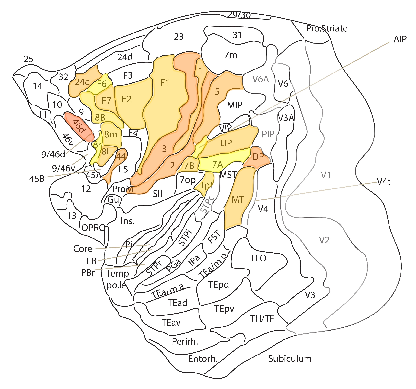

In [74]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
plot_brain_areas(ax, tvals.sel(times=2)) 

In [40]:
tvals.min()

<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    freqs    int64 35